In [1]:
##> import what you need

import numpy as np
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import scipy.ndimage
import random


##> make two scalers 


scaler_s= preprocessing.StandardScaler()
scaler_m= preprocessing.MinMaxScaler(feature_range=(0, 1))


Using TensorFlow backend.


In [28]:
hdr = fits.getheader('/home/bottrell/scratch/ProCNN/Photometry/Int/rInt-180-r.fits')
print(hdr)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  139                                                  NAXIS2  =                  139                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H DATE    = '2018-07-17T07:52:02' / Date and time of creation (UTC)               ORIGIN  = 'SKIRT simulation'   / Astronomical Observatory, Ghent University     BUNIT   = 'Relative'           / Physical unit of the array values              CRPIX1  =                256.5 / X-axis coordinate system reference pixel       CRVAL1  =                   0. / Coordinate system value at X-axis reference pixCDELT1  =             97.65625 / Coordin

In [24]:
##> list  fits files in different folders that you need as input (Change the paths). 
##> I choose only orbit 1 from G2G3_e with 540 member which will be be labeled by '1'

level = 'Photometry'
images_per_intrun = 180
images_per_isorun = 160
bands = ['g','r','i']

n_Iso = len(glob.glob('Iso/rIso*-r.fits'))
n_Int = len(glob.glob('Int/rInt*-r.fits'))

#wdir = '/home/bottrell/scratch/ProCNN/{}/'.format(level)
#if os.access(wdir,0): os.chdir(wdir)

# lst_GeO_1 = [glob.glob('orbit_1/p*.fits')]  ##> path to Fire/ObsRealism/G2G3_e/orbit_1. You should change it
#int_path = 'Int/'.format(level)
#iso_path = 'Iso/'.format(level)

int_path = 'Int/'
iso_path = 'Iso/'

# for G2G3_e orbit_1
int_list = ['{}rInt-{}-r.fits'.format(int_path,i) for i in range(n_Int)]

# for iso images (take all)
iso_list = ['{}rIso-{}-r.fits'.format(iso_path,i) for i in range(n_Iso)]

'''

##> you can list all if your fits files like this (I did not need these, for now):

#lst_GeO_2 = glob.glob('Fire/ObsRealism/G2G3_e/orbit_2/p*.fits')
#lst_GeO_3 = glob.glob('Fire/ObsRealism/G2G3_e/orbit_3/p*.fits')
#lst_GeO_4 = glob.glob('Fire/ObsRealism/G2G3_e/orbit_4/p*.fits')
#lst_GeO_5 = glob.glob('Fire/ObsRealism/G2G3_e/orbit_5/p*.fits')
#lst_GeO_6 = glob.glob('Fire/ObsRealism/G2G3_e/orbit_6/p*.fits')



##> Here I choose all iso images in folders G1 to G4 and then concatenate to make a list  
##> A member of the list is the path to a (iso) fits file. This list will be labeled by '0'

lst_iso_g1 = glob.glob('iso/G1/p*.fits')   ##> path to Fire/ObsRealism/iso/G1/
lst_iso_g2 = glob.glob('iso/G2/p*.fits')
lst_iso_g3 = glob.glob('iso/G3/p*.fits')
lst_iso_g4 = glob.glob('iso/G4/p*.fits')

lst_iso= np.concatenate((lst_iso_g1,lst_iso_g1,lst_iso_g1,lst_iso_g1),axis=0)  ##> 480 member (what I have)




##> so yo have two list lst_iso (class 0) and lst_GeO_1 (class 1) with differnt numbers (an unbalanced data, for now)

'''


"\n\n##> you can list all if your fits files like this (I did not need these, for now):\n\n#lst_GeO_2 = glob.glob('Fire/ObsRealism/G2G3_e/orbit_2/p*.fits')\n#lst_GeO_3 = glob.glob('Fire/ObsRealism/G2G3_e/orbit_3/p*.fits')\n#lst_GeO_4 = glob.glob('Fire/ObsRealism/G2G3_e/orbit_4/p*.fits')\n#lst_GeO_5 = glob.glob('Fire/ObsRealism/G2G3_e/orbit_5/p*.fits')\n#lst_GeO_6 = glob.glob('Fire/ObsRealism/G2G3_e/orbit_6/p*.fits')\n\n\n\n##> Here I choose all iso images in folders G1 to G4 and then concatenate to make a list  \n##> A member of the list is the path to a (iso) fits file. This list will be labeled by '0'\n\nlst_iso_g1 = glob.glob('iso/G1/p*.fits')   ##> path to Fire/ObsRealism/iso/G1/\nlst_iso_g2 = glob.glob('iso/G2/p*.fits')\nlst_iso_g3 = glob.glob('iso/G3/p*.fits')\nlst_iso_g4 = glob.glob('iso/G4/p*.fits')\n\nlst_iso= np.concatenate((lst_iso_g1,lst_iso_g1,lst_iso_g1,lst_iso_g1),axis=0)  ##> 480 member (what I have)\n\n\n\n\n##> so yo have two list lst_iso (class 0) and lst_GeO_1 (clas

### Data augmentation tests.

In [70]:
import numpy as np
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import scipy.ndimage
import random

'''Each image in the input array gets an integer number of
augmentations.'''

label = 'ObsRealism'
nChannels = (1 if label is 'StellarMap' else 3)
targetLen = 100
nSamples = 10

fileName = '/home/bottrell/scratch/RealCNN/MultiClass/Iso-{}-Inp.npy'.format(label)
x = np.load(fileName)[:nSamples]
# data must have shape (nRecords,nChannels,dx,dy) for augment
dx = dy = int(np.sqrt(x.shape[-1]))
x = x.reshape(-1,nChannels,dx,dy)
# Number of records
inputLen = x.shape[0]
# number of augmentations needed to roughly acheive target
n_augm = 0
# iteratively increase until output meets target size
while ((n_augm+1) * inputLen) < targetLen: n_augm+=1
if n_augm<1: 
    print('Input already exceeds target size.')
    sys.exit(0)
    
datagen = ImageDataGenerator(   
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='nearest',
        vertical_flip =True,
        zoom_range = 0.1,
        horizontal_flip =True,
        data_format= 'channels_first')


# generate empty augmented data array
x_augm = np.empty((n_augm*x.shape[0],x.shape[1],x.shape[2],x.shape[3]))
# fill augmented data array
for img_i in range(inputLen):
    for augm_i in range(n_augm): 
        x_augm[img_i+augm_i*inputLen] = datagen.flow(x[img_i].reshape((1,nChannels,dx,dy)), batch_size=1)[0]

fileOut = fileName.replace('Inp','InpAug')
# reshape inputs
x = x.reshape(-1,nChannels,dx*dy)
# reshape augmented to flatten images
x_augm = x_augm.reshape(-1,nChannels,dx*dy)
# save to output file
np.save(fileOut,np.concatenate([x,x_augm],axis=0))

# # Plot results
# print(x_augm.shape)
# from copy import copy
# cmap = copy(plt.cm.gray)
# cmap.set_bad('black')
# fig,axarr = plt.subplots(3,5,figsize=(10,6))
# print(x_augm[:,2].shape)
# for ax,img in zip(axarr.flatten()[0*nSamples:1*nSamples],x_augm[:,0]):
#     ax.imshow(np.log10(img.reshape(139,139)),cmap=cmap)
# for ax,img in zip(axarr.flatten()[1*nSamples:2*nSamples],x_augm[:,1]):
#     ax.imshow(np.log10(img.reshape(139,139)),cmap=cmap)
# for ax,img in zip(axarr.flatten()[2*nSamples:3*nSamples],x_augm[:,2]):
#     ax.imshow(np.log10(img.reshape(139,139)),cmap=cmap)
    
# # Plot results

# from copy import copy
# cmap = copy(plt.cm.gray)
# cmap.set_bad('black')
# fig,axarr = plt.subplots(6,6,figsize=(9,9))

# for ax,img in zip(axarr.flatten(),x_augm[:,0]):
#     ax.imshow(np.log10(img.reshape(139,139)),cmap=cmap)






(5, 3, 19321)
7
(40, 3, 19321)


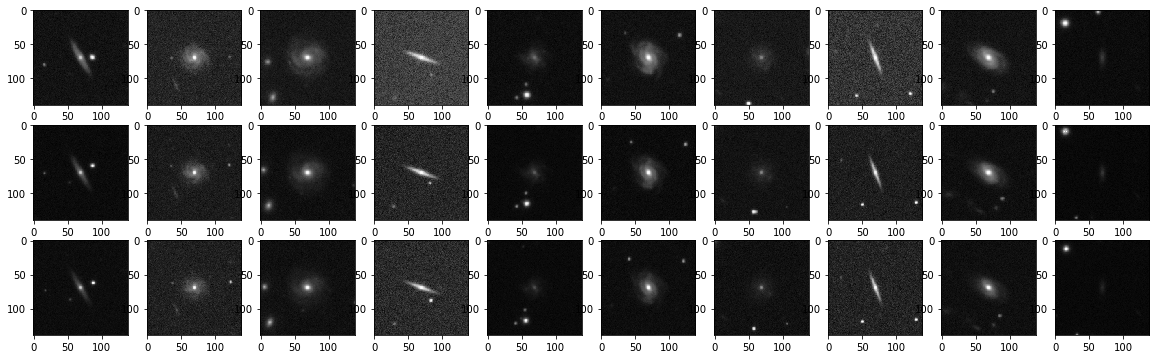

In [3]:
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt

nChannels = 3
dx = 139
dy = 139
#x = np.load('/home/bottrell/scratch/RealCNN/MultiClass/Iso-ObsRealism-InpAug.npy').reshape(-1,nChannels,dx,dy)
from copy import copy
cmap = copy(plt.cm.Greys_r)
cmap.set_bad('black')
fig,axarr = plt.subplots(3,10,figsize=(20,6))

for ax,img in zip(axarr.flatten()[:10],x[:10,0]):
    ax.imshow(np.log10(img.reshape(139,139)),cmap=cmap)
for ax,img in zip(axarr.flatten()[10:20],x[:10,1]):
    ax.imshow(np.log10(img.reshape(139,139)),cmap=cmap)
for ax,img in zip(axarr.flatten()[20:30],x[:10,2]):
    ax.imshow(np.log10(img.reshape(139,139)),cmap=cmap)


### Finalized Augmentation Script.

In [29]:
#!/usr/bin/env python
import numpy as np
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import scipy.ndimage
import random

targetLen = 10000
datagen = ImageDataGenerator(   
        rotation_range=180,
        width_shift_range=0.05,
        height_shift_range=0.05,
        fill_mode='nearest',
        vertical_flip =True,
        zoom_range = 0.1,
        horizontal_flip =True,
        data_format= 'channels_first')

'''Each image in the input array gets an integer number of
augmentations.'''

for label in ['StellarMap','Photometry','ObsRealism']:
    for classID in ['Iso','Pair','Post']:
        nChannels = (1 if label is 'StellarMap' else 3)
        fileName = '/home/bottrell/scratch/RealCNN/MultiClass/{}-{}-Inp.npy'.format(classID,label)
        x = np.load(fileName)
        # data must have shape (nRecords,nChannels,dx,dy) for augment
        dx = dy = int(np.sqrt(x.shape[-1]))
        x = x.reshape(-1,nChannels,dx,dy)
        # Number of records
        inputLen = x.shape[0]
        # number of augmentations needed to roughly acheive target
        n_augm = 0
        # iteratively increase until output meets target size
        while ((n_augm+1) * inputLen) < targetLen: n_augm+=1
        if n_augm<1: 
            print('Input already exceeds target size for {}-{}.'.format(classID,label))
            continue

        # generate empty augmented data array
        x_augm = np.empty((n_augm*x.shape[0],x.shape[1],x.shape[2],x.shape[3]))
        # fill augmented data array
        for img_i in range(inputLen):
            for augm_i in range(n_augm): 
                x_augm[img_i+augm_i*inputLen] = datagen.flow(x[img_i].reshape((1,nChannels,dx,dy)), batch_size=1)[0]

        fileOut = fileName.replace('Inp','InpAugTEST')
        # reshape inputs
        x = x.reshape(-1,nChannels,dx*dy)
        # reshape augmented to flatten images
        x_augm = x_augm.reshape(-1,nChannels,dx*dy)
        # save to output file
        np.save(fileOut,np.concatenate([x,x_augm],axis=0))
        print('Finished with file: {}'.format(fileOut))

### Normalize augmented data.

In [55]:
#!/usr/bin/env python
import numpy as np
import os
import matplotlib.pyplot as plt

# host directory
fileName = '/home/bottrell/scratch/RealCNN/MultiClass/{}-{}-InpAug.npy'
# careful of ordering here
tags = ['Iso','Pair','Post']
# data type from which to generate model
labels = ['StellarMap','Photometry','ObsRealism']

def normalize_inp(inp,lower_clip=50,upper_clip=99,window=20,params=None):
    xc = yc = int(inp.shape[-1]/2)
    dwinx = dwiny = int(window/2)
    if params is not None:
        a_min,a_max,norm = params
    else:
        # get rid of pesky values in the background
        inp[inp<-5]=np.nan
        # create window around target in which to perform max statistics
        statData = inp[:,:,xc-dwinx:xc+dwinx,yc-dwiny:yc+dwiny]
        # compute percentile in target window
        a_max = np.nanpercentile(statData,upper_clip,axis=(2,3))
        # obtain background estimate
        a_min = np.nanpercentile(inp,lower_clip,axis=(2,3))
        # normalization parameter
        norm = 1./(a_max - a_min)
    # loop over records and channels filling data
    for record in range(inp.shape[0]):
        for channel in range(inp.shape[1]):
            # normalize data
            inp[record,channel] = norm[record,channel]*(np.clip(inp[record,channel],a_min=a_min[record,channel],a_max=a_max[record,channel])-a_min[record,channel])
            # set all nans to zero on this scale
            inp[record,channel][np.isnan(inp[record,channel])]=0.
    params = [a_min,a_max,norm]
    return inp,params

dx = 139
dy = 139

for label in labels:
    nChannels = (1 if label is 'StellarMap' else 3)
    for tag in tags:
        x = np.load(fileName.format(tag,label))
        x = np.log10(x).reshape(-1,nChannels,139,139)
        x,params = normalize_inp(x,lower_clip=50,upper_clip=99)
        fileOut = fileName.format(tag,label).replace('Aug','AugNorm')
        np.save(fileOut,x)
        

In [61]:
print(len(x[np.isnan(x)]))

0


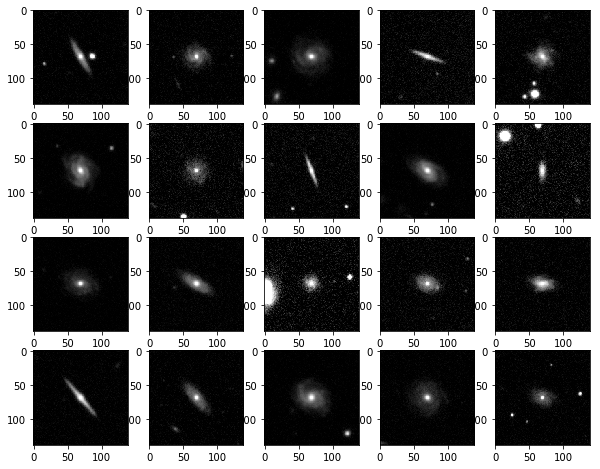

In [63]:
fig,axarr = plt.subplots(4,5,figsize=(10,8))
x = np.load('/home/bottrell/scratch/RealCNN/MultiClass/Iso-ObsRealism-InpAugNorm.npy')[:20]
data = x[:,0]
from copy import copy
cmap = copy(plt.cm.Greys_r)
cmap.set_bad('black')
for img,ax in zip(data,axarr.flatten()):
    ax.imshow(img,cmap=cmap,vmin=0,vmax=1)


In [39]:
##> Define the variables such as the size of the images, the number of augmented images and so on

tmp_hdr = fits.getheader(iso_list[0])
dx,dy = tmp_hdr['NAXIS1'],tmp_hdr['NAXIS2']  ##>  the size of imaxe x and y axes
del tmp_hdr
n_augm_int = 5 
n_augm_iso = 90
# softbias added to all images
softbias = 1. 

# for balancing
n_iso_total = images_per_isorun*n_augm_iso
random.seed(a=2319)
if n_augm_int<1:
    n_samples_int = n_Int
else:
    n_samples_int = int(n_iso_total/n_augm_int)
int_list_sample = random.sample(int_list,n_samples_int)



##> data augmentation: 
##> the following  function, augment, takes the input x with size (dx,dy) and transfoems that to (1,dx,dy) 
##> (because some parts need the images be in this new format). the argument n_augm shows the number 
##> of augmented images. For example, If n_augm = 10, then 10 diffrent images will be created (for each fits file) with 
##> diffrent rotations, width_shift_range and so on (i.e., with different combinations)




def augment(x,transforms,n_augm):   ##> the augmentation  function 
    if n_augm==True:
        x_r = np.reshape(x,(x.shape[0],1,x.shape[2],x.shape[3]))
    else:        
        x_r = np.reshape(x,(x.shape[0],1,x.shape[1],x.shape[2]))

    datagen = ImageDataGenerator(   ##>  you can change the following numbers or add more lines from Keras docs. However, they are good I think 
            rotation_range=180,
            width_shift_range=.1,
            height_shift_range=.1,            
            fill_mode='wrap',
            vertical_flip =True,
            zoom_range = 0.1,
            horizontal_flip =True,
            data_format= 'channels_first')
    
    if n_augm==True:
        x_new =  np.zeros((transforms*x.shape[0],1, x.shape[2],x.shape[3]))
    else:
        x_new =  np.zeros((transforms*x.shape[0],1, x.shape[2],x.shape[1]))

    for image in range(x.shape[0]):
        for transform in range(transforms): 
            x_new[image+transform*x.shape[0]]= datagen.flow(x_r[image].reshape((1,) + x_r[image].shape), batch_size=1)[0]

    return np.reshape(x_new,(x_new.shape[0],x_new.shape[2],x_new.shape[3]))


#balance_index = images_per_intrun-images_per_isorun
##> the list that input from  lst_GeO_1 (with all augmentations) will be appended (making input class 1)
inp_class_1=[]
for k1 in range(n_samples_int):     ##> we use only 480 out of 540 members to make a balanced data (if you want shuffle lst_GeO_1 first)
    file_= int_list_sample[k1]
    #print(file_)
    fits_ = fits.open(file_)    ##> open the fits files
    data = fits_[0].data ##>  take the pixel information in a matrix format
    data_aug = augment(np.reshape(data,(1,dx,dy)),n_augm_int,False)  ## augmentaion: we will have a list (n_augm,dx,dy) for each filts file
    for k2 in range(len(data_aug)):   ##>  in the following normalize and then append to group_1
        data = np.reshape(data_aug[k2],dy*dx)
        #min_ = min(data)
        data = scaler_m.fit_transform(np.reshape(data,(-1,1)))   # normalize the data after reshapeing 
        data = np.reshape(data,-1)    ##> make a one_d array for the next step (appending)
        inp_class_1.append(np.log10(data+softbias))  ##> to make sure that we have data>0; I chose min_/1000. you may want to use other thing

##> I chose log scale after normalization, You can use diffrent things to see the outputs
        
## > making a array 
inp_class_1=np.array(inp_class_1)
    
print(n_samples_int,n_samples_int*n_augm_int)
##> (making input class 0)    
inp_class_0=[]
for k1 in range(n_Iso):  ##> we use all 480 members of iso data. We could use len(lst_iso) instead 480 in the beraket.
    file_=iso_list[k1]
    fits_ = fits.open(file_)  
    data = fits_[0].data 
    data_aug = augment(np.reshape(data,(1,dx,dx)),n_augm_iso,False)  
    for k2 in range(len(data_aug)):      
        data = np.reshape(data_aug[k2],dx*dy)
        #min_ = min(data)  # find minimum
        data = scaler_m.fit_transform(np.reshape(data,(-1,1)))  
        data = np.reshape(data,-1)  
        inp_class_0.append(np.log10(data+softbias))  

## > making a array
inp_class_0=np.asarray(inp_class_0)    

print(inp_class_0.shape)
print(inp_class_1.shape)
##>  creat the total input  (total: 480+480)
X = np.concatenate((inp_class_1,inp_class_0),axis=0)


2880 14400
(14400, 19321)
(14400, 19321)


In [40]:
n_X= np.shape(X)[0]  ##> the number of total records 
n_1=np.shape(inp_class_1)[0]   ##> the number of the records in group 1 

Y=np.zeros(n_X)  ##> make a zero array with n_X member 
Y[0:n_1]=1        ##> change the first n_1 members from zero to 1  (the bibary target) 


print(np.shape(X))  ##> see the size of your input data
print(np.shape(Y))   ##> see the size of your target data

np.save('inp_01',X)  ##> save the input X as inp_01  (i,e,. the inout #1) 
np.save('tar_01',Y)   ##> save the input Y as tar_01 (i.e., the traget #1)



(28800, 19321)
(28800,)


0

In [1]:
#!/usr/bin/env python

from astropy.io import fits
from scipy import stats
import numpy as np
import os,sys,glob

output_shape = (139,139)
input_shape = (512,512)


def rebin(array, dimensions=None, scale=None):

    if dimensions is not None:
        if isinstance(dimensions, float):
            dimensions = [int(dimensions)] * len(array.shape)
        elif isinstance(dimensions, int):
            dimensions = [dimensions] * len(array.shape)
        elif len(dimensions) != len(array.shape):
            raise RuntimeError('')
    elif scale is not None:
        if isinstance(scale, float) or isinstance(scale, int):
            dimensions = map(int, map(round, map(lambda x: x*scale, array.shape)))
        elif len(scale) != len(array.shape):
            raise RuntimeError('')
    else:
        raise RuntimeError('Incorrect parameters to rebin.\n\trebin(array, dimensions=(x,y))\n\trebin(array, scale=a')
    #print "Rebinning to Dimensions: %s, %s" % tuple(dimensions)
    import itertools
    dY, dX = map(divmod, map(float, array.shape), dimensions)
 
    result = np.zeros(dimensions)
    for j, i in itertools.product(*map(range, array.shape)):
        (J, dj), (I, di) = divmod(j*dimensions[0], array.shape[0]), divmod(i*dimensions[1], array.shape[1])
        (J1, dj1), (I1, di1) = divmod(j+1, array.shape[0]/float(dimensions[0])), divmod(i+1, array.shape[1]/float(dimensions[1]))
         
        # Moving to new bin
        # Is this a discrete bin?
        dx,dy=0,0
        if (I1-I == 0) | ((I1-I == 1) & (di1==0)):
            dx = 1
        else:
            dx=1-di1
        if (J1-J == 0) | ((J1-J == 1) & (dj1==0)):
            dy=1
        else:
            dy=1-dj1
        # Prevent it from allocating outide the array
        I_=min(dimensions[1]-1,I+1)
        J_=min(dimensions[0]-1,J+1)
        result[J, I] += array[j,i]*dx*dy
        result[J_, I] += array[j,i]*(1-dy)*dx
        result[J, I_] += array[j,i]*dy*(1-dx)
        result[J_, I_] += array[j,i]*(1-dx)*(1-dy)
    allowError = 0.1
    assert (array.sum() < result.sum() * (1+allowError)) & (array.sum() >result.sum() * (1-allowError))
    return result


wdir = '/home/bottrell/scratch/RealCNN/'

bands = ['g','r','i']
'''
for label in ['Photometry','StellarMap']:
    for folder in ['Iso','Int']:
        os.chdir(wdir+'{}/{}'.format(label,folder))
        
        if label is 'Photometry':
            for i in range(len(glob.glob('{}-*-r.fits'.format(folder)))):
                for band in bands:
                    filename = '{}-{}-{}.fits'.format(folder,i,band)
                    outfile = 'r'+filename
                    if os.access(outfile,0): continue
                    hdr = fits.getheader(filename)
                    img_data = 10**(-0.4*(fits.getdata(filename)-22.5)) # nanomaggies/arcsec2
                    # conserve surface brightness (correction to flux conserved rebin function)
                    img_data = rebin(img_data,output_shape)*(float(output_shape[0])/input_shape[0])**2
                    hdr['NAXIS1']=output_shape[1]
                    hdr['NAXIS2']=output_shape[0]
                    hdr['BUNIT'] = 'AB nanomaggies/arcsec2'
                    fits.writeto(outfile,data=img_data,header=hdr)
                    
        if label is 'StellarMap':
            for i in range(len(glob.glob('{}-*.npz'.format(folder)))):
                filename = '{}-{}.npz'.format(folder,i)
                
                if os.access(outfile,0): continue
                f = np.load(filename,'r')
                # flux conserved but still a linear unit which can be easily scaled
                img_data = rebin(f['stellarmap'],output_shape)
                params = f['params'][()]
                f.close()
                # create fits header
                hdr = fits.Header()
                for key in params.keys():
                    if len(str(params[key]))<25:
                        hdr.append((key,params[key]))
                fits.writeto(outfile,data=img_data,header=hdr)
                
'''

"\nfor label in ['Photometry','StellarMap']:\n    for folder in ['Iso','Int']:\n        os.chdir(wdir+'{}/{}'.format(label,folder))\n        \n        if label is 'Photometry':\n            for i in range(len(glob.glob('{}-*-r.fits'.format(folder)))):\n                for band in bands:\n                    filename = '{}-{}-{}.fits'.format(folder,i,band)\n                    outfile = 'r'+filename\n                    if os.access(outfile,0): continue\n                    hdr = fits.getheader(filename)\n                    img_data = 10**(-0.4*(fits.getdata(filename)-22.5)) # nanomaggies/arcsec2\n                    # conserve surface brightness (correction to flux conserved rebin function)\n                    img_data = rebin(img_data,output_shape)*(float(output_shape[0])/input_shape[0])**2\n                    hdr['NAXIS1']=output_shape[1]\n                    hdr['NAXIS2']=output_shape[0]\n                    hdr['BUNIT'] = 'AB nanomaggies/arcsec2'\n                    fits.writet

In [44]:
#!/usr/bin/env python

from astropy.io import fits
from scipy import stats
import numpy as np
import os,sys,glob
import shutil

output_shape = (139,139)
input_shape = (512,512)


def rebin(array, dimensions=None, scale=None):

    if dimensions is not None:
        if isinstance(dimensions, float):
            dimensions = [int(dimensions)] * len(array.shape)
        elif isinstance(dimensions, int):
            dimensions = [dimensions] * len(array.shape)
        elif len(dimensions) != len(array.shape):
            raise RuntimeError('')
    elif scale is not None:
        if isinstance(scale, float) or isinstance(scale, int):
            dimensions = map(int, map(round, map(lambda x: x*scale, array.shape)))
        elif len(scale) != len(array.shape):
            raise RuntimeError('')
    else:
        raise RuntimeError('Incorrect parameters to rebin.\n\trebin(array, dimensions=(x,y))\n\trebin(array, scale=a')
    #print "Rebinning to Dimensions: %s, %s" % tuple(dimensions)
    import itertools
    dY, dX = map(divmod, map(float, array.shape), dimensions)
 
    result = np.zeros(dimensions)
    for j, i in itertools.product(*map(range, array.shape)):
        (J, dj), (I, di) = divmod(j*dimensions[0], array.shape[0]), divmod(i*dimensions[1], array.shape[1])
        (J1, dj1), (I1, di1) = divmod(j+1, array.shape[0]/float(dimensions[0])), divmod(i+1, array.shape[1]/float(dimensions[1]))
         
        # Moving to new bin
        # Is this a discrete bin?
        dx,dy=0,0
        if (I1-I == 0) | ((I1-I == 1) & (di1==0)):
            dx = 1
        else:
            dx=1-di1
        if (J1-J == 0) | ((J1-J == 1) & (dj1==0)):
            dy=1
        else:
            dy=1-dj1
        # Prevent it from allocating outide the array
        I_=min(dimensions[1]-1,I+1)
        J_=min(dimensions[0]-1,J+1)
        result[J, I] += array[j,i]*dx*dy
        result[J_, I] += array[j,i]*(1-dy)*dx
        result[J, I_] += array[j,i]*dy*(1-dx)
        result[J_, I_] += array[j,i]*(1-dx)*(1-dy)
    allowError = 0.1
    assert (array.sum() < result.sum() * (1+allowError)) & (array.sum() >result.sum() * (1-allowError))
    return result


wdir = '/home/bottrell/scratch/RealCNN/'
os.chdir(wdir)
Fire_path = '/home/bottrell/scratch/Fire/'
bands = ['g','r','i']

for label in ['ObsRealism','Photometry','StellarMap']:

    if label is 'StellarMap':
        file_list = glob.glob(Fire_path+'StellarMap/*/*/*.npz')[:10]
        for filename in file_list:
            if 'Iso' in filename:
                output_dir = wdir+'BinaryClass/{}/Iso/'.format(label)
                outfile = output_dir+filename.split('/')[-1].replace('.npz','.fits')
            else:
                output_dir = wdir+'BinaryClass/{}/Int/'.format(label)
                outfile = output_dir+filename.split('/')[-1].replace('.npz','.fits')
            if os.access(outfile,0): continue
            f = np.load(filename,'r')
            # flux conserved but still a linear unit which can be easily scaled
            img_data = rebin(f['stellarmap'],output_shape)
            params = f['params'][()]
            f.close()
            # create fits header
            hdr = fits.Header()
            for key in params.keys():
                if len(str(params[key]))<25:
                    hdr.append((key,params[key]))
            fits.writeto(outfile,data=img_data,header=hdr)
            
    if label is 'Photometry':
        file_list = glob.glob(Fire_path+'Photometry/*/*/photo_r*.fits')[:10]
        for filename in file_list:
            if 'Iso' in filename:
                output_dir = wdir+'BinaryClass/{}/Iso/'.format(label)
                outfile = output_dir+filename.split('/')[-1]
            else:
                output_dir = wdir+'BinaryClass/{}/Int/'.format(label)
                outfile = output_dir+filename.split('/')[-1]
            for band in bands:
                filename_x = filename.replace('photo_r','photo_{}'.format(band))
                outfile_x = outfile.replace('photo_r','photo_{}'.format(band))
                if os.access(outfile_x,0): continue
                hdr = fits.getheader(filename_x)
                img_data = 10**(-0.4*(fits.getdata(filename_x)-22.5)) # nanomaggies/arcsec2
                # conserve surface brightness (correction to flux conserved rebin function)
                img_data = rebin(img_data,output_shape)*(float(output_shape[0])/input_shape[0])**2
                hdr['NAXIS1']=output_shape[1]
                hdr['NAXIS2']=output_shape[0]
                hdr['BUNIT'] = 'AB nanomaggies/arcsec2'
                fits.writeto(outfile_x,data=img_data,header=hdr)
                
    if label is 'ObsRealism':
        file_list = glob.glob(Fire_path+'ObsRealism/*/*/*.fits')[:10]
        for filename in file_list:
            if 'Iso' in filename:
                output_dir = wdir+'BinaryClass/{}/Iso/'.format(label)
                outfile = output_dir+filename.split('/')[-1]
                if os.access(outfile,0):continue
                shutil.copy(filename,outfile)
            else:
                output_dir = wdir+'BinaryClass/{}/Int/'.format(label)
                outfile = output_dir+filename.split('/')[-1]
                if os.access(outfile,0):continue
                shutil.copy(filename,outfile)

sys.exit(0)

SystemExit: 0

/project/6020225/bottrell/virtualenvs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [47]:
#!/usr/bin/env python

from astropy.io import fits
from scipy import stats
import numpy as np
import os,sys,glob
import shutil

wdir = '/home/bottrell/scratch/RealCNN/'
os.chdir(wdir)
Fire_path = '/home/bottrell/scratch/Fire/'
bands = ['g','r','i']

for label in ['ObsRealism','Photometry','StellarMap']:

    if label is 'ObsRealism':
        file_list = glob.glob(Fire_path+'ObsRealism/*/*/*.fits')
        for filename in file_list:
            if 'Iso' in filename:
                output_dir = wdir+'BinaryClass/{}/Iso/'.format(label)
                outfile = output_dir+filename.split('/')[-1]
                if os.access(outfile,0):continue
                shutil.copy(filename,outfile)
            else:
                output_dir = wdir+'BinaryClass/{}/Int/'.format(label)
                outfile = output_dir+filename.split('/')[-1]
                if os.access(outfile,0):continue
                shutil.copy(filename,outfile)


In [90]:
#!/usr/bin/env python

from astropy.io import fits
from scipy import stats
import numpy as np
import os,sys,glob

wdir = '/home/bottrell/scratch/RealCNN/BinaryClass/'
input_shape = (139,139)
dx = input_shape[1]
dy = input_shape[0]

for label in ['StellarMap','Photometry','ObsRealism']:
    for cid in ['Iso','Int']:
        input_dir = wdir+label+'/'+cid+'/'
        
        if label is 'StellarMap':
            if os.access('{}-{}.npy'.format(cid,label),0): continue
            file_list = glob.glob(input_dir+'*.fits')
            output = np.empty((len(file_list),dx*dy))
            for i,file in enumerate(file_list):
                data = fits.getdata(file)
                output[i,:] = data.reshape((1,dx*dy))
            np.save('{}-{}.npy'.format(cid,label),output)
                
        if label is 'Photometry':
            if os.access('{}-{}.npy'.format(cid,label),0): continue
            file_list = glob.glob(input_dir+'photo_r*.fits')
            output = np.empty((len(file_list),3,dx*dy))
            for i,file in enumerate(file_list):
                data_g = fits.getdata(file.replace('photo_r','photo_g'))
                data_r = fits.getdata(file)
                data_i = fits.getdata(file.replace('photo_r','photo_i'))
                output[i] = np.array([data_g,data_r,data_i]).reshape(3,dx*dy)
            np.save('{}-{}.npy'.format(cid,label),output)
            
        if label is 'ObsRealism':
            if os.access('{}-{}.npy'.format(cid,label),0): continue
            file_list = glob.glob(input_dir+'photo_r*.fits')
            output = np.empty((len(file_list),3,dx*dy))
            for i,file in enumerate(file_list):
                data_g = fits.getdata(file.replace('photo_r','photo_g'))
                data_r = fits.getdata(file)
                data_i = fits.getdata(file.replace('photo_r','photo_i'))
                output[i] = np.array([data_g,data_r,data_i]).reshape(3,dx*dy)
            np.save('{}-{}.npy'.format(cid,label),output)

            
'''        
print(output.shape)
output = output.reshape(-1,3,dx,dy)
print(output.shape)
print(output[0,0].shape)
fig,axarr=plt.subplots(1,3,figsize=(15,5))
objID = 3
axarr[0].imshow(-2.5*np.log10(output[objID,0]*0.396**2/1.046**4)+22.5,vmin=14,vmax=30,cmap='Blues_r')
axarr[1].imshow(-2.5*np.log10(output[objID,1]*0.396**2/1.046**4)+22.5,vmin=14,vmax=30,cmap='Greens_r')
axarr[2].imshow(-2.5*np.log10(output[objID,2]*0.396**2/1.046**4)+22.5,vmin=14,vmax=30,cmap='Reds_r')
'''

        
    
    
    

/home/bottrell/scratch/RealCNN/BinaryClass/ObsRealism/Iso/photo_r_CNN_Iso-G4_011_i3_sci.fits
/home/bottrell/scratch/RealCNN/BinaryClass/ObsRealism/Int/photo_r_CNN_MassRatioOrbits-mass_ratio_6_081_i0_sci.fits


"        \nprint(output.shape)\noutput = output.reshape(-1,3,dx,dy)\nprint(output.shape)\nprint(output[0,0].shape)\nfig,axarr=plt.subplots(1,3,figsize=(15,5))\nobjID = 3\naxarr[0].imshow(-2.5*np.log10(output[objID,0]*0.396**2/1.046**4)+22.5,vmin=14,vmax=30,cmap='Blues_r')\naxarr[1].imshow(-2.5*np.log10(output[objID,1]*0.396**2/1.046**4)+22.5,vmin=14,vmax=30,cmap='Greens_r')\naxarr[2].imshow(-2.5*np.log10(output[objID,2]*0.396**2/1.046**4)+22.5,vmin=14,vmax=30,cmap='Reds_r')\n"

(100, 3, 139, 139)


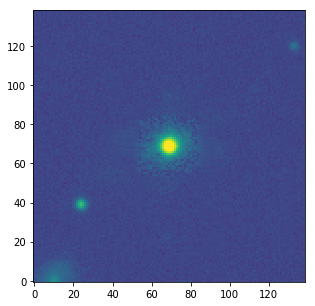

In [116]:
#!/usr/bin/env python

from astropy.io import fits
from scipy import stats
import numpy as np
import os,sys,glob

wdir = '/home/bottrell/scratch/RealCNN/BinaryClass/'
input_shape = (139,139)
dx = input_shape[1]
dy = input_shape[0]

for label in ['StellarMap','Photometry','ObsRealism']:
    for cid in ['Iso','Int']:
        input_dir = wdir+label+'/'+cid+'/'
        
        if label is 'StellarMap':
            if os.access('{}-{}.npy'.format(cid,label),0): continue
            file_list = glob.glob(input_dir+'*.fits')
            output = np.empty((len(file_list),dx*dy))
            for i,file in enumerate(file_list):
                data = fits.getdata(file)
                output[i,:] = data.reshape((1,dx*dy))
            np.save('{}-{}.npy'.format(cid,label),output)
                
        if label is 'Photometry':
            if os.access('{}-{}.npy'.format(cid,label),0): continue
            file_list = glob.glob(input_dir+'photo_r*.fits')
            output = np.empty((len(file_list),3,dx*dy))
            for i,file in enumerate(file_list):
                data_g = fits.getdata(file.replace('photo_r','photo_g'))
                data_r = fits.getdata(file)
                data_i = fits.getdata(file.replace('photo_r','photo_i'))
                output[i] = np.array([data_g,data_r,data_i]).reshape(3,dx*dy)
            np.save('{}-{}.npy'.format(cid,label),output)
            
        if label is 'ObsRealism':
            if os.access('{}-{}.npy'.format(cid,label),0): continue
            file_list = glob.glob(input_dir+'photo_r*.fits')
            output = np.empty((len(file_list),3,dx*dy))
            for i,file in enumerate(file_list):
                data_g = fits.getdata(file.replace('photo_r','photo_g'))
                data_r = fits.getdata(file)
                data_i = fits.getdata(file.replace('photo_r','photo_i'))
                output[i] = np.array([data_g,data_r,data_i]).reshape(3,dx*dy)
            np.save('{}-{}.npy'.format(cid,label),output)

            

/project/6020225/bottrell/virtualenvs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


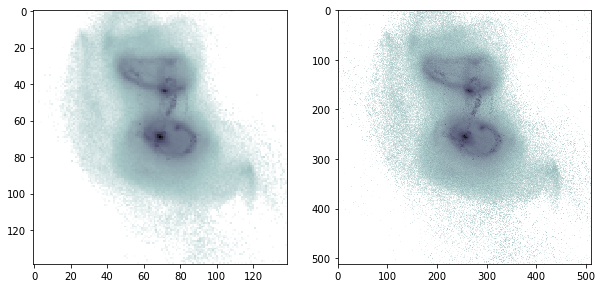

In [21]:
fig,axarr = plt.subplots(1,2,figsize=(10,5))
filename = '/home/bottrell/scratch/RealCNN/BinaryClass/Photometry/Int/photo_r_CNN_G2G3_e-orbit_1_298_i0_total.fits'
data = fits.getdata(filename)
axarr[0].imshow(-2.5*np.log10(data)+22.5,vmin=14,vmax=28.3,cmap='bone',)

filename = '/home/bottrell/scratch/Fire/Photometry/G2G3_e/orbit_1/photo_r_CNN_G2G3_e-orbit_1_298_i0_total.fits'
data = fits.getdata(filename)
axarr[1].imshow(data,vmin=14,vmax=28.3,cmap='bone',)

In [43]:
import shutil

In [119]:
23*45*4*4.6/10

1904.4

# Process input

In [15]:
import numpy as np
import matplotlib.pyplot as plt

file_Iso = '/home/bottrell/scratch/RealCNN/Iso-StellarMap.npy'
file_Int = '/home/bottrell/scratch/RealCNN/Int-StellarMap.npy'

data_Iso = np.log10(np.load(file_Iso))
data_Int = np.log10(np.load(file_Int))

iso_len = len(data_Iso)
int_len = len(data_Int)

# put augmentation here

inp_name = '/home/bottrell/scratch/RealCNN/BinaryClass/StellarMap_inp.npy'
tar_name = '/home/bottrell/scratch/RealCNN/BinaryClass/StellarMap_tar.npy'

# isolated galaxies have class 0
tar_data = np.zeros(iso_len+int_len)
# interacting galaxies have class 1
tar_data[iso_len:] = 1
# save to file
np.save(tar_name,tar_data)

# concatenate iso and int data
inp_data = np.concatenate((data_Iso,data_Int),axis=0)
# save to file
np.save(inp_name,inp_data)






NameError: name 'ls' is not defined

### Populate Fire-r directory

Populate Fire-r directory with images from Fire directory. This script is now in the Generate_Fire-r.py file. It also resizes the StellarMap and Photometry files to match the 139x139 dimensions of the ObsRealism files. It does not handle the new data with SemiReal and FullReal files.

In [15]:
#!/usr/bin/env python

from astropy.io import fits
from scipy import stats
import numpy as np
import os,sys,glob
from shutil import copyfile


output_shape = (139,139)
input_shape = (512,512)


def rebin(array, dimensions=None, scale=None):

    if dimensions is not None:
        if isinstance(dimensions, float):
            dimensions = [int(dimensions)] * len(array.shape)
        elif isinstance(dimensions, int):
            dimensions = [dimensions] * len(array.shape)
        elif len(dimensions) != len(array.shape):
            raise RuntimeError('')
    elif scale is not None:
        if isinstance(scale, float) or isinstance(scale, int):
            dimensions = map(int, map(round, map(lambda x: x*scale, array.shape)))
        elif len(scale) != len(array.shape):
            raise RuntimeError('')
    else:
        raise RuntimeError('Incorrect parameters to rebin.\n\trebin(array, dimensions=(x,y))\n\trebin(array, scale=a')
    #print "Rebinning to Dimensions: %s, %s" % tuple(dimensions)
    import itertools
    dY, dX = map(divmod, map(float, array.shape), dimensions)
 
    result = np.zeros(dimensions)
    for j, i in itertools.product(*map(range, array.shape)):
        (J, dj), (I, di) = divmod(j*dimensions[0], array.shape[0]), divmod(i*dimensions[1], array.shape[1])
        (J1, dj1), (I1, di1) = divmod(j+1, array.shape[0]/float(dimensions[0])), divmod(i+1, array.shape[1]/float(dimensions[1]))
         
        # Moving to new bin
        # Is this a discrete bin?
        dx,dy=0,0
        if (I1-I == 0) | ((I1-I == 1) & (di1==0)):
            dx = 1
        else:
            dx=1-di1
        if (J1-J == 0) | ((J1-J == 1) & (dj1==0)):
            dy=1
        else:
            dy=1-dj1
        # Prevent it from allocating outide the array
        I_=min(dimensions[1]-1,I+1)
        J_=min(dimensions[0]-1,J+1)
        result[J, I] += array[j,i]*dx*dy
        result[J_, I] += array[j,i]*(1-dy)*dx
        result[J, I_] += array[j,i]*dy*(1-dx)
        result[J_, I_] += array[j,i]*(1-dx)*(1-dy)
    allowError = 0.1
    assert (array.sum() < result.sum() * (1+allowError)) & (array.sum() >result.sum() * (1-allowError))
    return result

def get_imgList(snapFile,path,label,sim_tag,sub_tag,imgType):
    # full image list associated with a particular file
    imgList = []
    # load snapFile and get snapID list
    with np.load(snapFile_name,mmap_mode='r') as f:
        snapIDs = np.asarray(f['snapID']).astype(int)
    # get filenames for every file in list
    for snapID in snapIDs:
        imgCall = '{}{}/{}/{}/*{:03}_i*{}'.format(Fire_path,label,sim_tag,sub_tag,snapID,imgType)
        imgList+=glob.glob(imgCall)
    return imgList
    
wdir = '/home/bottrell/scratch/RealCNN/Fire-r/'
os.chdir(wdir)
Fire_path = '/home/bottrell/scratch/Fire/'
labels = ['Photometry','StellarMap','ObsRealism']
bands = ['g','r','i']

snapFile_list = glob.glob(Fire_path+'GalSep/*.npz')

for label in ['StellarMap','Photometry','ObsRealism']:
    
    if label is 'StellarMap': imgType = '.npz'
    else: imgType = '.fits'
        
    for snapFile_name in snapFile_list:
        # remove full path from filename
        sF = snapFile_name.split('/')[-1]
        # obtain image list for each snap file
        if 'G2G3' in sF:
            chars = sF.split('_')
            sim_tag = '{}_{}'.format(chars[1],chars[2])
            sub_tag = '{}_{}'.format(chars[3],chars[4])
            imgList = get_imgList(snapFile_name,Fire_path,label,sim_tag,sub_tag,imgType)
        if 'MassRatioOrbits' in sF:
            chars = sF.split('_')
            sim_tag = '{}'.format(chars[1])
            sub_tag = '{}_{}_{}'.format(chars[2],chars[3],chars[4])
            imgList = get_imgList(snapFile_name,Fire_path,label,sim_tag,sub_tag,imgType)
        if 'Iso' in sF:
            chars = sF.split('_')
            sim_tags = ['Iso','ext_Iso']
            sub_tag = '{}'.format(chars[0])
            imgList=[]
            for sim_tag in sim_tags:
                imgList+=get_imgList(snapFile_name,Fire_path,label,sim_tag,sub_tag,imgType)
            
            
        # define output directory for given snap file
        if 'Pair' in sF:
            output_dir = '{}{}/Pair/'.format(wdir,label)
        if 'PM' in sF:
            output_dir = '{}{}/Post/'.format(wdir,label)
        if 'Iso' in sF:
            output_dir = '{}{}/Iso/'.format(wdir,label)
        
        if label is 'StellarMap':
            for imgName in imgList:
                outfile = output_dir+imgName.split('/')[-1].replace('.npz','.fits')
                if os.access(outfile,0): continue
                f = np.load(imgName,'r')
                # flux conserved but still a linear unit which can be easily scaled
                img_data = rebin(f['stellarmap'],output_shape)
                params = f['params'][()]
                f.close()
                # create fits header
                hdr = fits.Header()
                for key in params.keys():
                    if len(str(params[key]))<25:
                        hdr.append((key,params[key]))
                fits.writeto(outfile,data=img_data,header=hdr)
                
        if label is 'Photometry':
            for imgName in imgList:
                outfile = output_dir+imgName.split('/')[-1]
                if os.access(outfile,0): continue
                hdr = fits.getheader(imgName)
                img_data = 10**(-0.4*(fits.getdata(imgName)-22.5)) # nanomaggies/arcsec2
                # conserve surface brightness (correction to flux conserved rebin function)
                img_data = rebin(img_data,output_shape)*(float(output_shape[0])/input_shape[0])**2
                hdr['NAXIS1']=output_shape[1]
                hdr['NAXIS2']=output_shape[0]
                hdr['BUNIT'] = 'AB nanomaggies/arcsec2'
                fits.writeto(outfile,data=img_data,header=hdr)
                
        if label is 'ObsRealism':
            for imgName in imgList:
                outfile = output_dir+imgName.split('/')[-1]
                if os.access(outfile,0): continue
                copyfile(imgName,outfile)

        

sys.exit(0)

/home/bottrell/scratch/Fire/GalSep/galsep_G2G3_f_orbit_1_PairSnapIDs.npz


KeyboardInterrupt: 

### Populate Fire_Images_CNN directory

Fire_Images_CNN is a new directory which contains the SemiReal and StellarMap_FullReal images. The Photometry, StellarMap, and Photometry_FullReal files were copied directly from the Fire-r directory with Globus. This script fills the other image-type directories with the corresponding images from the Fire directory. No images need to be rebinned.

In [2]:
#!/usr/bin/env python

from astropy.io import fits
from scipy import stats
import numpy as np
import os,sys,glob
from shutil import copyfile

def get_imgList(snapFile,path,label,sim_tag,sub_tag,imgType):
    # full image list associated with a particular file
    imgList = []
    # load snapFile and get snapID list
    with np.load(snapFile_name,mmap_mode='r') as f:
        snapIDs = np.asarray(f['snapID']).astype(int)
    # get filenames for every file in list
    for snapID in snapIDs:
        imgCall = '{}{}/{}/{}/*{:03}_i*{}'.format(Fire_path,label,sim_tag,sub_tag,snapID,imgType)
        imgList+=glob.glob(imgCall)
    return imgList


wdir = '/home/bottrell/scratch/RealCNN/Fire_Images_CNN/'
os.chdir(wdir)
Fire_path = '/home/bottrell/scratch/Fire/'
labels = ['Photometry_SemiReal','StellarMap_SemiReal','StellarMap_FullReal']
bands = ['g','r','i']
imgType='.fits'

snapFile_list = glob.glob(Fire_path+'GalSep/*.npz')

for label in labels:
        
    for snapFile_name in snapFile_list:
        # remove full path from filename
        sF = snapFile_name.split('/')[-1]
        # obtain image list for each snap file
        if 'G2G3' in sF:
            chars = sF.split('_')
            sim_tag = '{}_{}'.format(chars[1],chars[2])
            sub_tag = '{}_{}'.format(chars[3],chars[4])
            imgList = get_imgList(snapFile_name,Fire_path,label,sim_tag,sub_tag,imgType)
        if 'MassRatioOrbits' in sF:
            chars = sF.split('_')
            sim_tag = '{}'.format(chars[1])
            sub_tag = '{}_{}_{}'.format(chars[2],chars[3],chars[4])
            imgList = get_imgList(snapFile_name,Fire_path,label,sim_tag,sub_tag,imgType)
        if 'Iso' in sF:
            chars = sF.split('_')
            sim_tags = ['Iso','ext_Iso']
            sub_tag = '{}'.format(chars[0])
            imgList=[]
            for sim_tag in sim_tags:
                imgList+=get_imgList(snapFile_name,Fire_path,label,sim_tag,sub_tag,imgType)
            
        # define output directory for given snap file
        if 'Pair' in sF:
            output_dir = '{}{}/Pair/'.format(wdir,label)
        if 'PM' in sF:
            output_dir = '{}{}/Post/'.format(wdir,label)
        if 'Iso' in sF:
            output_dir = '{}{}/Iso/'.format(wdir,label)
        
        for imgName in imgList:
            outfile = output_dir+imgName.split('/')[-1]
            if os.access(outfile,0): continue
            copyfile(imgName,outfile)

        

sys.exit(0)

KeyboardInterrupt: 

### Move all test data to numpy file

In [1]:
#!/usr/bin/env python

'''
Put all data from DR14_Manga_Pipe3d into single file with 
associated target classification file. 

Requirements:
Python3
mariadb connection
'''

from astropy.io import fits
from scipy import stats
import numpy as np
import os,sys,glob
from shutil import copyfile
import pymysql

# test image dimensions 
dx = 139
dy = 139
# number of channels
nChannels = 3
# overwrite existing?
overwrite = False

# directory containing test images
testDir = '/home/bottrell/scratch/DR14_Manga_Pipe3D/Gimages/'
# path to output file
outputInp = '/home/bottrell/scratch/DR14_Manga_Pipe3D/Files/DR14_Manga_Pipe3d-Inp.npy'
outputTar = '/home/bottrell/scratch/DR14_Manga_Pipe3D/Files/DR14_Manga_Pipe3d-Tar.npy'
if os.access(outputInp,0): 
    if overwrite: 
        os.remove(outputInp)
        os.remove(outputTar)
    else:
        print('Output file "{}" already exists. Exiting...'.format(outputInp))
        sys.exit(0)

table_all = 'dr14_manga_pipe3d'
table_mergers = 'dr14_manga_mergers'
db = pymysql.connect(host='cedar-mysql-vm.int.cedar.computecanada.ca',
                     db='bottrell_sdss',read_default_file='/home/bottrell/.my.cnf')
c = db.cursor()
dbcmd = ['SELECT',
         'a.objID',
         'FROM',
         '{} as a'.format(table_all)]
c.execute(str.join(' ',dbcmd))
objIDs_all = np.asarray(c.fetchall()).astype(int).flatten()
dbcmd = ['SELECT',
         'a.objID',
         'FROM',
         '{} as a JOIN'.format(table_all),
         '{} as m ON'.format(table_mergers),
         'a.objID=m.objID']
c.execute(str.join(' ',dbcmd))
objIDs_mergers = np.asarray(c.fetchall()).astype(int).flatten()
dbcmd = ['SELECT',
         'a.objID',
         'FROM',
         '{} as a JOIN'.format(table_all),
         '{} as m ON'.format(table_mergers),
         'a.objID=m.objID',
         'WHERE rp=0.']
c.execute(str.join(' ',dbcmd))
# post objIDs are those with rp=0 in the manga_mergers table
objIDs_post = np.asarray(c.fetchall()).astype(int).flatten()
c.close()
db.close()

# isolated objIDs are those not in the merger set but in the full set
objIDs_iso = [(objID not in objIDs_mergers) for objID in objIDs_all]
objIDs_iso = objIDs_all[objIDs_iso]
# pair objIDs are those not in the post set set but in the merger set
objIDs_pair = [(objID not in objIDs_post) for objID in objIDs_mergers]
objIDs_pair = objIDs_mergers[objIDs_pair]

classDict = {}
for objID in objIDs_iso:
    classDict[str(objID)] = 0
for objID in objIDs_pair:
    classDict[str(objID)] = 1
for objID in objIDs_post:
    classDict[str(objID)] = 2

# list all r-band images
imgList = glob.glob(testDir+'*-r.fits')
# input data 
inpData = np.empty((len(imgList),nChannels,dx*dy))
# target data
tarData = np.zeros(len(imgList))

for i,imgName in enumerate(imgList):
    objID = imgName.split('/')[-1].split('_')[0]
    data_g = fits.getdata(imgName.replace('-r.fits','-g.fits'))
    data_r = fits.getdata(imgName)
    data_i = fits.getdata(imgName.replace('-r.fits','-i.fits'))
    inpData[i] = np.array([data_g,data_r,data_i]).reshape(3,dx*dy)
    tarData[i] = classDict[objID]
np.save(outputInp,inpData)
np.save(outputTar,tarData)


Output file "/home/bottrell/scratch/DR14_Manga_Pipe3D/Files/DR14_Manga_Pipe3d-Inp.npy" already exists. Exiting...


SystemExit: 0

/project/6020225/bottrell/virtualenvs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### View images from test data.

1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.9999999999999999 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.9999999999999999 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.9999999999999999 0.0
1.0 0.0
1.0 0.0
0.9999999999999999 0.0
1.0 0.0
0.9999999999999999 0.0
1.0 0.0
1.0 0.0


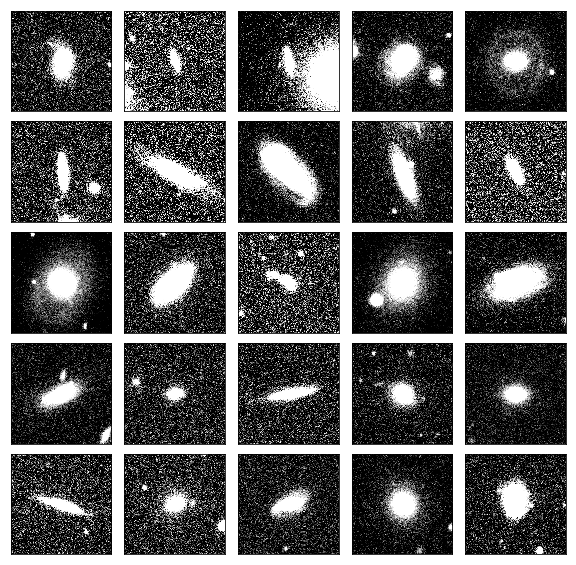

In [17]:
# import matplotlib.pyplot as plt
# import numpy as np

# outputInp = '/home/bottrell/scratch/DR14_Manga_Pipe3D/Files/DR14_Manga_Pipe3d-Inp.npy'
# outputTar = '/home/bottrell/scratch/DR14_Manga_Pipe3D/Files/DR14_Manga_Pipe3d-Tar.npy'
# inp = np.load(outputInp)
# tar = np.load(outputTar)

indices = np.argwhere(tar==0).flatten()
seed = np.random.seed(42)
indices = np.random.choice(indices,25,replace=False)

fig,axarr=plt.subplots(5,5,figsize=(10,10))
fig.subplots_adjust(wspace=0.1,hspace=0.1)
pix = int(10/2)

def normalize_inp(inp,lower_clip=50,upper_clip=99,params=None):
    '''Custom minmax normalization. Return normalized data and 
    normalization parameters so that the same normalization can
    be used on test data, for example.'''
    if params is not None:
        a_min,a_max,norm = params
    else:
        a_max = np.nanpercentile(inp,upper_clip,axis=2)
        a_min = np.nanpercentile(inp,lower_clip,axis=2)
        norm = 1./(a_max-a_min)
    for jj in range(inp.shape[0]):
        for ii in range(inp.shape[1]):
            inp[jj,ii] = norm[jj,ii]*(np.clip(inp[jj,ii],a_min=a_min[jj,ii],a_max=a_max[jj,ii])-a_min[jj,ii])
            inp[jj,ii][np.isnan(inp[jj,ii])]=0.
    params = [a_min,a_max,norm]
    return inp,params


for img,ax in zip(inp[indices],axarr.flatten()): 
    img = np.log10(img[0].reshape(139,139))
    sky = np.nanpercentile(img,50)
    Ipix = np.nanmax(img[69-pix:69+pix,69-pix:69+pix])
    norm = 1./(Ipix-sky)
    
    img = norm*(np.clip(img,a_min=sky,a_max=Ipix)-sky)
    print(np.max(img),np.min(img))
    

    ax.tick_params(axis='x',which='both',bottom=False,
                   top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,
                   right=False,labelleft=False)
    ax.imshow(img,vmin=0,vmax=0.1,cmap='Greys_r')
    
fig.savefig('DR14_MangaPipe3D_TestImgs_lowcontrast.pdf',bbox_inches='tight')

(9, 1, 139, 139)
(1, 139, 139)
(1, 139, 139)
(1, 139, 139)
(1, 139, 139)
(1, 139, 139)
(1, 139, 139)
(1, 139, 139)
(1, 139, 139)
(1, 139, 139)


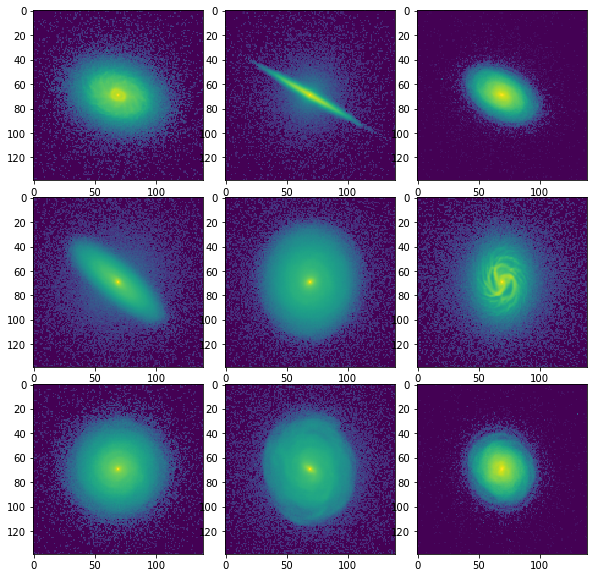

### Generate Augmented Data

In [73]:
#!/usr/bin/env python
import numpy as np
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import scipy.ndimage
import random

cat_header = '# SIMTAG SUBTAG ISNAP CAMERA\n'
targetLen = 10000
datagen = ImageDataGenerator(   
        rotation_range=180,
        width_shift_range=0.05,
        height_shift_range=0.05,
        fill_mode='nearest',
        vertical_flip =True,
        zoom_range = 0.1,
        horizontal_flip =True,
        data_format= 'channels_first')

'''Each image in the input array gets an integer number of
augmentations.'''

for label in ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
              'Photometry','Photometry_SemiReal','Photometry_FullReal']:
    
    for classID in ['Iso','Pair','Post']:
        
        nChannels = (1 if 'StellarMap' in label else 3)
        # data file name
        fileName = '/home/bottrell/scratch/RealCNN/MultiClass/Data/{}-{}-Inp.npy'.format(classID,label)
        fileOut = fileName.replace('Inp','InpAug')
        if os.access(fileOut,0): continue
        # corresponding catalog file name
        catName = '/home/bottrell/scratch/RealCNN/MultiClass/Data/{}-{}.cat'.format(classID,label)
        catOut = catName.replace('.cat','_catAug.npy')
        x = np.load(fileName)
        c = np.loadtxt(catName,dtype=str,delimiter=' ')
        # data must have shape (nRecords,nChannels,dx,dy) for augment
        dx = dy = int(np.sqrt(x.shape[-1]))
        x = x.reshape(-1,nChannels,dx,dy)
        # Number of records
        inputLen = x.shape[0]
        # number of augmentations needed to roughly acheive target
        n_augm = 0
        # iteratively increase until output meets target size
        while ((n_augm+1) * inputLen) < targetLen: n_augm+=1
        if n_augm<1: 
            print('Input already exceeds target size.')
            sys.exit(0)

        fileOut = fileName.replace('Inp','InpAug')
        catOut = catName.replace('.cat','_catAug.npy')
        # generate empty augmented data array
        x_augm = np.empty((n_augm*x.shape[0],x.shape[1],x.shape[2],x.shape[3]))
        c_augm = np.empty((n_augm*inputLen,4),dtype=object)
        
        # fill augmented data array
        for img_i in range(inputLen):
            for augm_i in range(n_augm): 
                x_augm[img_i+augm_i*inputLen] = datagen.flow(x[img_i].reshape((1,nChannels,dx,dy)), batch_size=1)[0]
                c_augm[img_i+augm_i*inputLen] = c[img_i]

        # reshape inputs
        x = x.reshape(-1,nChannels,dx*dy)
        # reshape augmented to flatten images
        x_augm = x_augm.reshape(-1,nChannels,dx*dy)
        # save to output file
        np.save(fileOut,np.concatenate([x,x_augm],axis=0))
        np.save(catOut,np.concatenate([c,c_augm],axis=0))
        print('Finished with file: {}'.format(fileOut))


Finished with file: /home/bottrell/scratch/RealCNN/MultiClass/Data/Iso-StellarMap-InpAug.npy
Finished with file: /home/bottrell/scratch/RealCNN/MultiClass/Data/Pair-StellarMap-InpAug.npy
Finished with file: /home/bottrell/scratch/RealCNN/MultiClass/Data/Post-StellarMap-InpAug.npy
Finished with file: /home/bottrell/scratch/RealCNN/MultiClass/Data/Iso-StellarMap_SemiReal-InpAug.npy
Finished with file: /home/bottrell/scratch/RealCNN/MultiClass/Data/Pair-StellarMap_SemiReal-InpAug.npy
Finished with file: /home/bottrell/scratch/RealCNN/MultiClass/Data/Post-StellarMap_SemiReal-InpAug.npy
Finished with file: /home/bottrell/scratch/RealCNN/MultiClass/Data/Iso-StellarMap_FullReal-InpAug.npy
Finished with file: /home/bottrell/scratch/RealCNN/MultiClass/Data/Pair-StellarMap_FullReal-InpAug.npy
Finished with file: /home/bottrell/scratch/RealCNN/MultiClass/Data/Post-StellarMap_FullReal-InpAug.npy


MemoryError: 

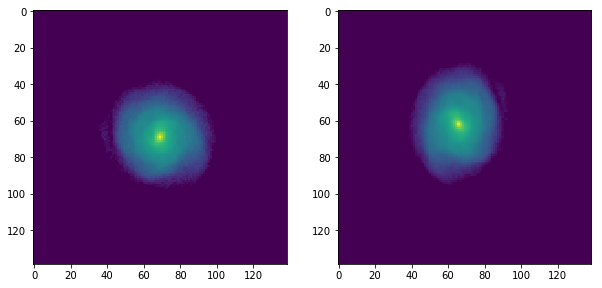

In [72]:
# Show that the image is the same but augmented in steps of n_augm*InputLen

import numpy as np
import matplotlib.pyplot as plt

catalog = '/home/bottrell/scratch/RealCNN/MultiClass/Data/Iso-StellarMap_Aug_cat.npy'
c = np.load(catalog)

x = np.load('/home/bottrell/scratch/RealCNN/MultiClass/Data/Iso-StellarMap-InpAug.npy')
fig,axarr = plt.subplots(1,2,figsize=(10,5))

axarr[0].imshow(np.log10(x[3291].reshape(1,139,139)[0]),vmin=4,vmax=7)
axarr[1].imshow(np.log10(x[5000+3291].reshape(1,139,139)[0]),vmin=4,vmax=7)




### Normalize Augmented Data

In [1]:
#!/usr/bin/env python
import numpy as np
import os

# host directory
fileName = '/home/bottrell/scratch/RealCNN/MultiClass/Data/{}-{}-InpAug.npy'
# careful of ordering here
tags = ['Iso','Pair','Post']
# data type from which to generate model
labels = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
          'Photometry','Photometry_SemiReal','Photometry_FullReal']

def normalize_inp(inp,lower_clip=50,upper_clip=99,window=20,params=None):
    xc = yc = int(inp.shape[-1]/2)
    dwinx = dwiny = int(window/2)
    if params is not None:
        a_min,a_max,norm = params
    else:
        # get rid of pesky values in the background
        inp[inp<-5]=np.nan
        # create window around target in which to perform max statistics
        statData = inp[:,:,xc-dwinx:xc+dwinx,yc-dwiny:yc+dwiny]
        # compute percentile in target window
        a_max = np.nanpercentile(statData,upper_clip,axis=(2,3))
        # obtain background estimate
        a_min = np.nanpercentile(inp,lower_clip,axis=(2,3))
        # normalization parameter
        norm = 1./(a_max - a_min)
    # loop over records and channels filling data
    for record in range(inp.shape[0]):
        for channel in range(inp.shape[1]):
            # normalize data
            inp[record,channel] = norm[record,channel]*(np.clip(inp[record,channel],a_min=a_min[record,channel],a_max=a_max[record,channel])-a_min[record,channel])
            # set all nans to zero on this scale
            inp[record,channel][np.isnan(inp[record,channel])]=0.
    params = [a_min,a_max,norm]
    return inp,params

dx = 139
dy = 139

for label in labels:
    nChannels = (1 if 'StellarMap' in label else 3)
    for tag in tags:
        fileOut = fileName.format(tag,label).replace('Aug','AugNorm')
        if os.access(fileOut,0): continue
        x = np.load(fileName.format(tag,label))
        x = np.log10(x).reshape(-1,nChannels,139,139)
        x,params = normalize_inp(x,lower_clip=50,upper_clip=99)
        np.save(fileOut,x)

/project/6020225/bottrell/virtualenvs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in log10
/project/6020225/bottrell/virtualenvs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


FileNotFoundError: [Errno 2] No such file or directory: '/home/bottrell/scratch/RealCNN/MultiClass/Data/Iso-Photometry-InpAug.npy'